In [1]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import plotly

import commot as ct

plotly_colors = plotly.colors.qualitative.Alphabet

In [16]:
def plot_cluster(X, labels, colors, s=2, filename=None, legend=False, legend_markerscale=1.0):
    unique_labels = np.sort(list(set(list(labels))))
    # unique_labels = list(set(list(labels)))
    print(unique_labels)
    cnt = 0
    for label in unique_labels:
        idx = np.where(labels == label)[0]
        plt.scatter(X[idx,0], X[idx,1], s=s, c=colors[cnt], label=label, linewidth=0)
        cnt += 1
    plt.axis('off')
    plt.axis('equal')
    if legend:
        plt.legend(markerscale=legend_markerscale, loc=7, bbox_to_anchor=(1.2, 0.5, 0.25, 0.25))
    if not filename is None:
        plt.tight_layout()
        plt.savefig(filename)

In [22]:
adata = sc.read_h5ad("./data/adata.h5ad")

In [23]:
# Cell type annotation from Giotto
df_celltype = pd.read_csv('./data/celltype_annotation.csv', index_col=0)
celltypes = list(df_celltype.values.reshape(-1))
adata.obs['celltype_annotation'] = pd.Series(list(celltypes), dtype="category").values

['Adarb2 iNeuron' 'L2/3 eNeuron' 'L4 eNeuron' 'L5 eNeuron' 'L6 eNeuron'
 'Lhx6 iNeuron' 'OPC' 'Olig' 'astrocytes' 'endothelial' 'microglia'
 'mural']


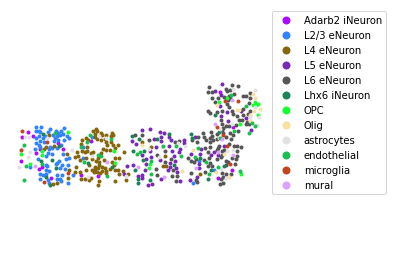

In [24]:
pts = adata.obsm['spatial']
plot_cluster(pts, np.array(celltypes, str), plotly.colors.qualitative.Alphabet, s=16, legend=True, legend_markerscale=2, filename='./figure/clustering_celltype.pdf')

### **Cluster spots based on signaling activity**

In [48]:
X_r = adata.obsm['commot-cellchat-sum-receiver'].values
colname_r = list( adata.obsm['commot-cellchat-sum-receiver'].columns.values )
X_s = adata.obsm['commot-cellchat-sum-sender'].values
colname_s = list( adata.obsm['commot-cellchat-sum-sender'].columns.values )
X_signal = np.concatenate( (X_r, X_s), axis=1 )
colname = colname_r + colname_s
adata_signal = anndata.AnnData(X=X_signal, var=pd.DataFrame(index=colname))

In [49]:
sc.tl.pca(adata_signal, svd_solver='arpack')
sc.pp.neighbors(adata_signal, n_neighbors=10, n_pcs=20)
sc.tl.leiden(adata_signal, resolution=.3)

[0 1 2 3 4]


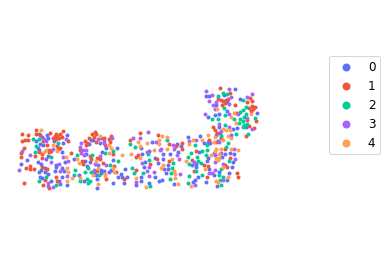

In [50]:
pts = adata.obsm['spatial']
labels = np.array( adata_signal.obs['leiden'], int )
plot_cluster(pts, labels, plotly.colors.qualitative.Plotly, s=16, legend=True, legend_markerscale=2, filename='./figure/clustering_ccc.pdf')

### **Differential signaling activity analysis with CCC based clustering**

In [51]:
sc.tl.rank_genes_groups(adata_signal, 'leiden', method='wilcoxon')

categories: 0, 1, 2, etc.
var_group_labels: 0, 2, 3, etc.


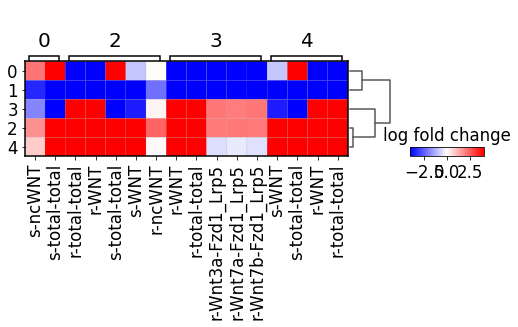

categories: 0, 1, 2, etc.
var_group_labels: 0, 2, 3, etc.


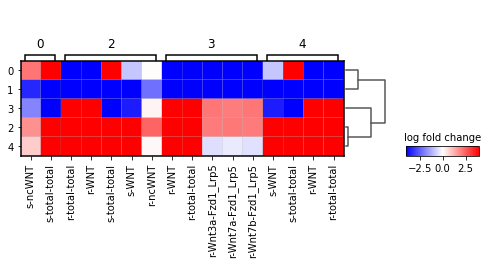

In [52]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

sc.pl.rank_genes_groups_matrixplot(
    adata_signal,
    n_genes=5,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=2,
    colorbar_title='log fold change',
    groupby='leiden',
    save='ccc_cluster_bigfont.pdf'
)

mpl.rcParams['font.size'] = 12
sc.pl.rank_genes_groups_matrixplot(
    adata_signal,
    n_genes=5,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=2,
    colorbar_title='log fold change',
    groupby='leiden',
    save='ccc_cluster_smallfont.pdf'
)

### **Differential signaling activity with cell type based clustering**

In [54]:
adata_signal.obs['celltype'] = adata.obs['celltype_annotation']

In [55]:
sc.tl.rank_genes_groups(adata_signal, 'celltype', method='wilcoxon')

categories: Adarb2 iNeuron, L2/3 eNeuron, L4 eNeuron, etc.
var_group_labels: Adarb2 iNeuron, L4 eNeuron, L5 eNeuron, etc.


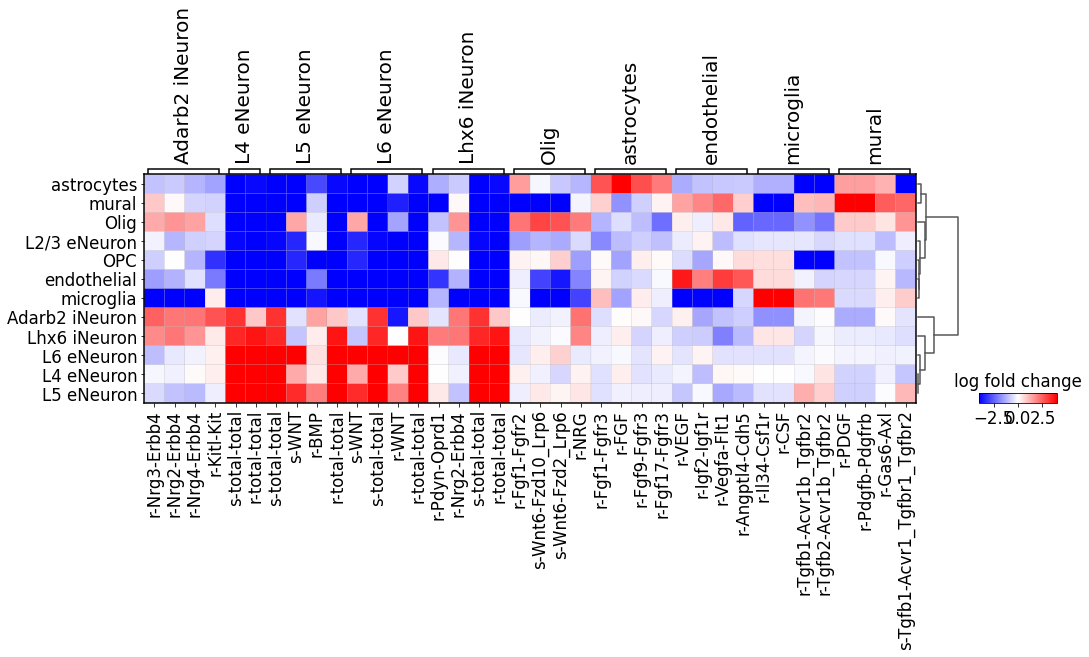

categories: Adarb2 iNeuron, L2/3 eNeuron, L4 eNeuron, etc.
var_group_labels: Adarb2 iNeuron, L4 eNeuron, L5 eNeuron, etc.


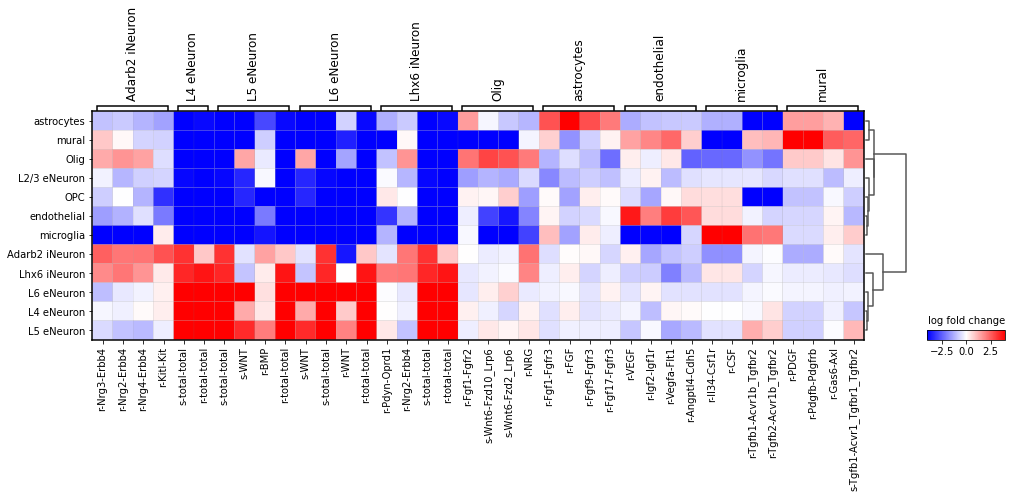

In [57]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

sc.pl.rank_genes_groups_matrixplot(
    adata_signal,
    n_genes=4,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=2,
    colorbar_title='log fold change',
    groupby='celltype',
    save='ccc_celltype_bigfont.pdf'
)

mpl.rcParams['font.size'] = 12
sc.pl.rank_genes_groups_matrixplot(
    adata_signal,
    n_genes=4,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-4,
    vmax=4,
    min_logfoldchange=2,
    colorbar_title='log fold change',
    groupby='celltype',
    save='ccc_celltype_smallfont.pdf'
)

### **Differential gene expression analysis with CCC based clustering**

In [58]:
adata.obs['leiden_signal'] = adata_signal.obs['leiden']

In [59]:
sc.tl.rank_genes_groups(adata, 'leiden_signal', method='wilcoxon')

         Falling back to preprocessing with `sc.pp.pca` and default params.


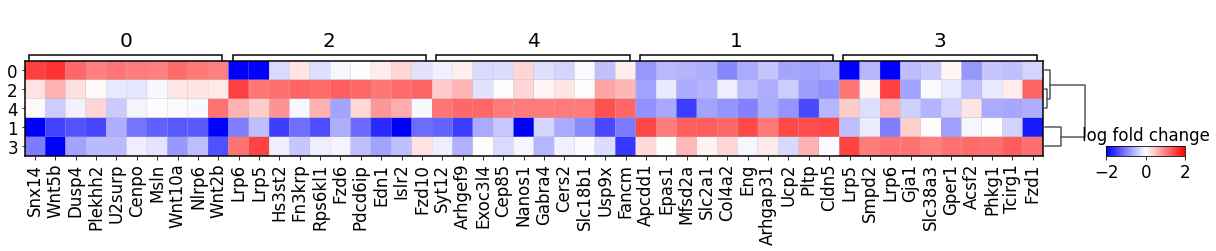

In [61]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

sc.pl.rank_genes_groups_matrixplot(
    adata,
    n_genes=10,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-2,
    vmax=2,
    min_logfoldchange=1,
    colorbar_title='log fold change',
    groupby='leiden_signal',
    save='matplot-de-ccc_clustering_bigfont.pdf'
)